# Introduction

Lorem Ipsum...

In this example we will be computing the *radial distribution function* TODO add link to documentation...when that documentation is online...get that added to the website!

To calculate the radial distribution function TODO (add in math to actual section?), we will need to follow the following workflow:

1. Load data
2. Create Freud RDF object
3. Compute the RDF
4. Extract data from the Freud RDF object
5. (optional) Plot data

# Required Packages

We will use the following python packages, please install with your favorite package manager:

* matplotlib - plotting
* numpy - general scientific goodness
* glotzformats - to load trajectories

In [4]:
%matplotlib inline
import numpy as np
from cycler import cycler
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter, MultipleLocator, ScalarFormatter
from matplotlib.colors import colorConverter
import glotzformats
# these are settings I enjoy, feel free to use your own
myHexColors = ["#30A2DA", "#FC4F30", "#E5AE38", "#6D904F", "#9757DB",
               "#188487", "#FF7F00", "#9A2C66", "#626DDA", "#8B8B8B"]
myColorCycle = [colorConverter.to_rgb(i) for i in myHexColors]
my_marker_cycle = ["o", "^", "s", "p", "D", "v", "8", "h", "+", "."]
plt.rc('axes', prop_cycle=(cycler("color", myColorCycle) + 
                           cycler("marker", my_marker_cycle)))

# Set Up Freud

Now we need to import freud to our environment. In this case, we will import specific modules rather than import the whole of freud. Feel free to just use

    import freud

as you see fit.

In [2]:
from freud import parallel, box, density
parallel.setNumThreads(4)

We imported the following modules:

* parallel - allows you to set the number of threads you will use during calculations. Yes, Freud is parallelized!
    - By default freud will use the maximum number of threads available on your machine. Here, I set it to 4, please set as needed on your machine. If working on a shared machine, consider using a moderate number of threads.
    - Don't forget to benchmark your calculations, or refer to the freud benchmarks to determine the optimal number of cores to use. More is not always better!
* box - module used to create the simulation boxes used in freud calculations
* density - module containing density-related calculations, including the radial distribution function

# Loading Data

Freud makes no assumptions about your data, and doesn't provide a method to load specified formats, everything passed into freud must be a `np.ndarray` of type required by freud (see documentation). In this example the glotzformats reader is used. Due to the contextual nature of glotzformats, a tiny example is included below, but will not be explained:

In [8]:
gsd_reader = glotzformats.reader.GSDHOOMDFileReader()
data_path = "/nfs/glotzer/projects/EntropicBonding/2016/10/04102016/DataP0.55000/Run0/EntropicBonding.gsd"
with open(data_path, "rb") as gsd_file:
    traj = gsd_reader.read(gsd_file)
    # other code will go here

# Create the RDF Object

Each module in Freud contains a number of available computations. In order to perform any computations, you need to create an instance of the object. Please refer to the documentation for what arguments need to be supplied for the compute module you wish to use.

Let's create the RDF object. For your convenience, we use the help function to show what needs to be supplied:

In [11]:
help(density.RDF)

Help on class RDF in module freud._freud:

class RDF(builtins.object)
 |  Computes RDF for supplied data
 |  
 |  The RDF (g(r)) is computed and averaged for a given set of reference points in a sea of data points. Providing the
 |  same points calculates them against themselves. Computing the RDF results in an rdf array listing the value of the
 |  RDF at each given r, listed in the r array.
 |  
 |  The values of r to compute the rdf are set by the values of rmax, dr in the constructor. rmax sets the maximum
 |  distance at which to calculate the g(r) while dr determines the step size for each bin.
 |  
 |  .. moduleauthor:: Eric Harper <harperic@umich.edu>
 |  
 |  .. note::
 |      2D: RDF properly handles 2D boxes. Requires the points to be passed in [x, y, 0]. Failing to z=0 will lead to         undefined behavior.
 |  
 |  :param rmax: maximum distance to calculate
 |  :param dr: distance between histogram bins
 |  :type rmax: float
 |  :type dr: float
 |  
 |  Methods defined h

It looks like the constructor takes in `rmax` and `dr` as parameters, or the maximum distance to calculate the rdf, and the size of the rdf histogram bin e.g. `r_max = 10` and `dr = 0.1`:

In [12]:
rdf = density.RDF(rmax=10.0, dr=0.1)

# Compute the RDF

It's time to actually compute the rdf, so here we go, what is happening is briefly explained in the comments

In [22]:
gsd_reader = glotzformats.reader.GSDHOOMDFileReader()
data_path = "/nfs/glotzer/projects/EntropicBonding/2016/10/04102016/DataP0.55000/Run0/EntropicBonding.gsd"
with open(data_path, "rb") as gsd_file:
    traj = gsd_reader.read(gsd_file)
    # just for the last frame in the trajectory
    frame = traj[-1]
    # create the box
    gbox = frame.box
    fbox = box.Box(Lx=gbox.Lx, Ly=gbox.Ly, is2D=True)
    # get the positions
    pos = frame.positions
    # compute
    rdf.compute(fbox, pos, pos)

# I computed the RDF, now what?

You might be thinking to yourself "ok, now what?" First, you need to get your data out of freud. Second, you need to visualize that data.

## Getting your data out of Freud

That sweet, sweet RDF data is currently in C++, but we want it in python, so let's get it out of there!

In [23]:
# get the center of the histogram bins
r = rdf.getR()
# get the value of the histogram bins
y = rdf.getRDF()

## Visualizing your data

Remember, Freud makes no assumptions about your data or how you want to visualize it. Want to use matplotlib like we do here? Go right ahead. Want to be a heathen and use Excel? Go right ahead, no one is stopping you (except your conscience...don't use Excel)

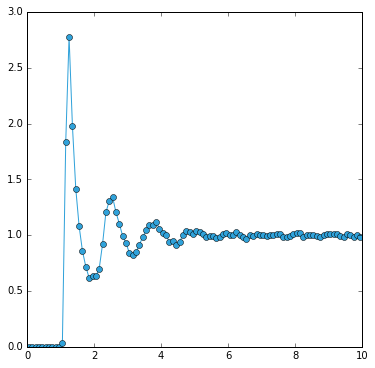

In [24]:
# create matplotlib plot
fig = plt.figure(figsize=(6,6))
# create axes
ax = fig.add_subplot(111)
ax.plot(r, y, label="rdf")
plt.show()

# Accumulate, or how I stopped worrying and let Freud do trivial tasks for me

A lot of times we want to average our data over many simualtion frames. Freud does this for you with the `accumulate` method: 

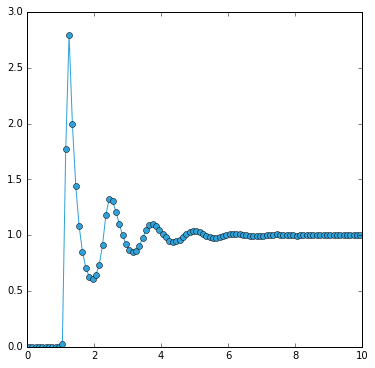

In [27]:
with open(data_path, "rb") as gsd_file:
    traj = gsd_reader.read(gsd_file)
    # for all frames except the first (your syntax will vary based on your reader)
    for frame in traj[1:]:
        # create the box
        gbox = frame.box
        fbox = box.Box(Lx=gbox.Lx, Ly=gbox.Ly, is2D=True)
        # get the positions
        pos = frame.positions
        # compute
        rdf.accumulate(fbox, pos, pos)

# get the center of the histogram bins
r = rdf.getR()
# get the value of the histogram bins
y = rdf.getRDF()
# create matplotlib plot
fig = plt.figure(figsize=(6,6))
# create axes
ax = fig.add_subplot(111)
ax.plot(r, y, label="rdf")
plt.show()

# What's the difference?

Let's plot together and find out:

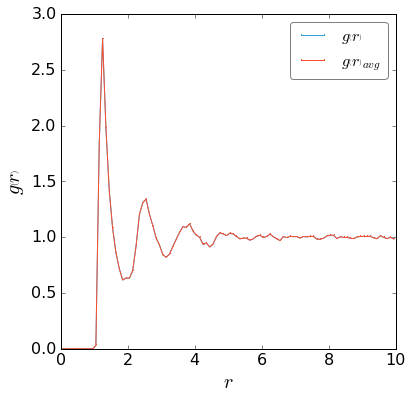

In [34]:
# reset the rdf; required if not using compute
rdf.resetRDF()
with open(data_path, "rb") as gsd_file:
    traj = gsd_reader.read(gsd_file)
    # for all frames except the first (your syntax will vary based on your reader)
    for frame in traj[1:]:
        # create the box
        gbox = frame.box
        fbox = box.Box(Lx=gbox.Lx, Ly=gbox.Ly, is2D=True)
        # get the positions
        pos = frame.positions
        # compute
        rdf.accumulate(fbox, pos, pos)

# get the center of the histogram bins
r_avg = rdf.getR()
# get the value of the histogram bins
y_avg = rdf.getRDF()
with open(data_path, "rb") as gsd_file:
    traj = gsd_reader.read(gsd_file)
    # for all frames except the first (your syntax will vary based on your reader)
    frame = traj[-1]
    # create the box
    gbox = frame.box
    fbox = box.Box(Lx=gbox.Lx, Ly=gbox.Ly, is2D=True)
    # get the positions
    pos = frame.positions
    # compute
    rdf.compute(fbox, pos, pos)
# get the center of the histogram bins
r = rdf.getR()
# get the value of the histogram bins
y = rdf.getRDF()
# create matplotlib plot
fig = plt.figure(figsize=(6,6))
# create axes
ax = fig.add_subplot(111)
ax.plot(r, y, marker=",", label=r"$g\left(r\right)$")
ax.plot(r_avg, y_avg, marker=",", label=r"$g\left(r\right)_{avg}$")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc=0, frameon=True, fontsize=16,
          ncol=1, fancybox=True, framealpha=0.5)
ax.set_xlabel(r"$r$")
ax.set_ylabel(r"$g \left( r \right)$")
ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
plt.show()

# Wait a second, there's no difference?!

Right you are, but there should be...

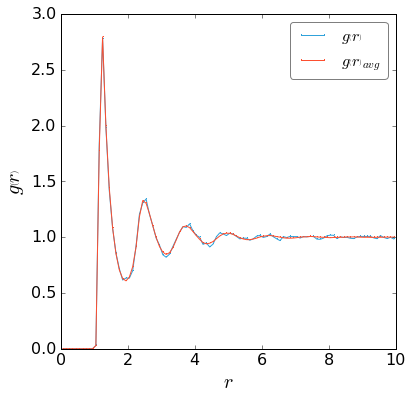

In [33]:
# reset the rdf; required if not using compute
rdf.resetRDF()
with open(data_path, "rb") as gsd_file:
    traj = gsd_reader.read(gsd_file)
    # for all frames except the first (your syntax will vary based on your reader)
    for frame in traj[1:]:
        # create the box
        gbox = frame.box
        fbox = box.Box(Lx=gbox.Lx, Ly=gbox.Ly, is2D=True)
        # get the positions
        pos = frame.positions
        # compute
        rdf.accumulate(fbox, pos, pos)

# get the center of the histogram bins
r_avg = np.copy(rdf.getR())
# get the value of the histogram bins
y_avg = np.copy(rdf.getRDF())
with open(data_path, "rb") as gsd_file:
    traj = gsd_reader.read(gsd_file)
    # for all frames except the first (your syntax will vary based on your reader)
    frame = traj[-1]
    # create the box
    gbox = frame.box
    fbox = box.Box(Lx=gbox.Lx, Ly=gbox.Ly, is2D=True)
    # get the positions
    pos = frame.positions
    # compute
    rdf.compute(fbox, pos, pos)
# get the center of the histogram bins
r = rdf.getR()
# get the value of the histogram bins
y = rdf.getRDF()
# create matplotlib plot
fig = plt.figure(figsize=(6,6))
# create axes
ax = fig.add_subplot(111)
ax.plot(r, y, marker=",", label=r"$g\left(r\right)$")
ax.plot(r_avg, y_avg, marker=",", label=r"$g\left(r\right)_{avg}$")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc=0, frameon=True, fontsize=16,
          ncol=1, fancybox=True, framealpha=0.5)
ax.set_xlabel(r"$r$")
ax.set_ylabel(r"$g \left( r \right)$")
ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
plt.show()

# Pointers vs. Copies

By default Freud returns a numpy array *as a pointer*. This is done for speed, but can result in the above problem. Please be sure to copy your data out as need be.